# Two Moons: Tackling Bimodal Posteriors

## Table of Contents
 * [Simulator](#simulator)
 * [Dataset](#dataset)
 * [Training](#nn-training)
 * [Validation](#validation)
 * [Further Experimentation](#further_experimentation)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm

import keras

## REMOVE ON PRODUCTION
# TODO: what is the point of these lines?
import sys
sys.path.append('../')

import bayesflow as bf

## Simulator<a class="anchor" id="simulator"></a>

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables" (data to be learned from), $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, and $r \sim \text{Normal}(0.1, 0.01)$ being latent variables creating noise in the data, and $\theta = (\theta_1, \theta_2)$ being the parameters that we will later seek to infer from new $x$. We set their priors to

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1).
\end{align}
$$

This model is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows.

Let's code up the above described `simulator` for use in Bayesflow:

In [16]:
# TODO

The thus created simulator is the same as the one available in bayesflow benchmark module:

In [17]:
simulator = bf.benchmarks.TwoMoons()

## Dataset <a class="anchor" id="dataset"></a>

Next, we will create training and validation data for the bayesflow training phase:

In [18]:
num_train_simulations = 10000
train_data = simulator.sample(batch_shape=num_train_simulations)

num_val_simulations = 300
val_data = simulator.sample(batch_shape=num_val_simulations)

# TODO: show the structure of the training data?

To make sure BayesFlow knows how to deal with all the just simulated variables, we have to tell which are considered observables to condition on ("inference_conditions") and which are variables to infer later on ("inference_variables"). For this purpose, we use the `data_adapter` functionality:

In [19]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

Next, we create the `dataset` object that are used for 
training our deep approximators. In a nutshell, they are a combination of 
our simulated (training) data and the data adapter we just built. 
These datasets will also help use taking care of batching during training.

In [20]:
batch_size = 128

train_dataset = bf.datasets.OfflineDataset(
    train_data, batch_size=batch_size, data_adapter=data_adapter
)
print(f"Number of training batches: {train_dataset.num_batches}")

val_dataset = bf.datasets.OfflineDataset(
    val_data, batch_size=batch_size, data_adapter=data_adapter
)
print(f"Number of validation batches: {val_dataset.num_batches}")

Number of training batches: 79
Number of validation batches: 3
Number of training batches: 79
Number of validation batches: 3


## Traing a neural network to approximate all posteriors <a class="anchor" id="nn-training"></a>

### Flow matching as a posterior approximator

With the training dataset prepared, we turn our attention to setting up 
the neural network that will learn to infer the posterior over $\theta$ 
from any observable input $x$ within the scope of our training data. 
We choose to use a flow matching architecture for this example since
it can deal well with the multimodal nature of the posteriors that some
observables imply.

In [21]:
inference_network = bf.networks.FlowMatching(
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

This inference network is just a general flow matching architecure, not yet adapted to the specific inference task at hand. To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

In [22]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

### Optimizer and learning rate

Before we can start with the actual training, we have to set up our optimizer. 
Below, we show several of the hyperparameters users can adjust in the built-in Keras3 optimizers.
For this particular example, most of these hyperparameters don't really matter, but 
you should make sure that TODO is not too large.

In [23]:
epochs = 300

# TODO: do we really need to set all of these manually for this simple example?

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=epochs * train_dataset.num_batches,
    alpha=1e-7,
    warmup_target=1e-3,
    warmup_steps=int(0.1 * epochs * train_dataset.num_batches),
)

optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-3
)

approximator.compile(optimizer=optimizer)

### Training

We are ready to train our deep posterior approximator on the TwoMoons example:

In [ ]:
# TODO: can we show the training less verbosely? 300 epochs create a lot of output in an ipy notebook
history = approximator.fit(
    epochs=epochs,
    dataset=train_dataset,
    workers=None,
    use_multiprocessing=False,
)

## Validation <a class="anchor" id="validation"></a>

### Two Moons Posterior <a class="anchor" id="two_moons_posterior"></a>

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. 
These results suggest that our flow matching setup can approximate the expected analytical posterior well.

(-0.5, 0.5)

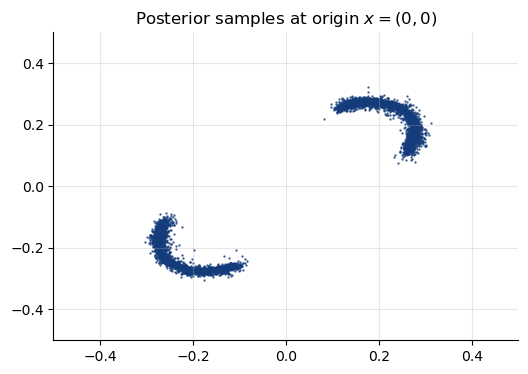

In [25]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Obtain samples from amortized posterior
obs_data = [0, 0]
samples_at_origin = approximator.sample(conditions={"observables": obs_data}, num_samples=num_samples)["parameters"]

# Prepare figure
f, axes = plt.subplots(1, figsize=(6, 4))

# Plot samples
axes.scatter(samples_at_origin[0, :, 0], samples_at_origin[0, :, 1], color="#153c7a", alpha=0.75, s=0.5)
sns.despine(ax=axes)
axes.set_title(r"Posterior samples at origin $x=(0, 0)$")
axes.grid(alpha=0.3)
axes.set_xlim([-0.5, 0.5])
axes.set_ylim([-0.5, 0.5])


The posterior looks as we have expected in this case. However, in general, we do not know how the posterior is supposed to look like for any specific dataset. As such, we need diagnostics that validate the correctness of the inferred posterior. One such diagnostic is simulation-based calibration(SBC), which we can apply for free due to amortization. For more details on SBC and the create diagnostic plots, see:

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. *arXiv preprint*.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. *Statistics and Computing*.

In [26]:
# Will be added soon.

## Further Experimentation <a class="anchor" id="further_experimentation"></a>

In [27]:
# Will be added soon.